<a href="https://colab.research.google.com/github/alirezashadmani/Deep-Learning-Computer-Vision/blob/master/Image_Segmentation_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, concatenate


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = ''
original_images = os.path.join(path, '../content/drive/MyDrive/semantic_drone_dataset/original_images/')
mask_images = os.path.join(path, '../content/drive/MyDrive/semantic_drone_dataset/label_images/')

image_list = os.listdir(original_images)
mask_list = os.listdir(mask_images)

image_list = [original_images+i for i in image_list]
mask_list = [mask_images+i for i in mask_list]

image_list = sorted(image_list)
mask_list = sorted(mask_list)
print("Number of Images : {} " .format(len(mask_list)))

print(image_list[0])
print(mask_list[0])

Number of Images : 400 
../content/drive/MyDrive/semantic_drone_dataset/original_images/000.jpg
../content/drive/MyDrive/semantic_drone_dataset/label_images/000.png


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Mask Image')

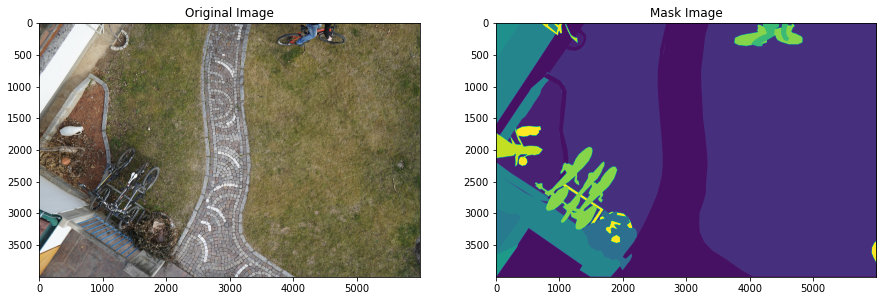

In [5]:
n = 15
img = imageio.imread(image_list[n])
print(img.shape)
mask = imageio.imread(mask_list[n])
print(mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(15, 10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask Image')

In [6]:
image_list_dataset = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list, shuffle=False)
images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((images_filenames, 
                                              masks_filenames))
for image, mask in dataset.take(1):
  print(image)
  print(mask)

tf.Tensor(b'../content/drive/MyDrive/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'../content/drive/MyDrive/semantic_drone_dataset/label_images/000.png', shape=(), dtype=string)


In [7]:
def process_path(original_images, mask_images):
  img = tf.io.read_file(original_images)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  mask = tf.io.read_file(mask_images)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  return img, mask

def preprocess(image, mask):
  input_image = tf.image.resize(image, (96, 128), method='nearest')
  input_mask = tf.image.resize(mask, (96, 128), method='nearest')

  return input_image, input_mask

image_ds = dataset.map(process_path)
print(image_ds)
processed_image_ds = image_ds.map(preprocess)

<MapDataset shapes: ((None, None, 3), (None, None, 1)), types: (tf.float32, tf.uint8)>


In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
  conv = Conv2D(n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
  conv = Conv2D(n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer=tf.keras.initializers.HeNormal())(conv)
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  if max_pooling:
    next_layer = MaxPooling2D(pool_size=(2,2))(conv)

  else:
    next_layer = conv

  skip_connection = conv
  return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

  up = Conv2DTranspose(n_filters,
                       kernel_size=3,
                       activation='relu',
                       strides=(2,2),
                       padding='same')(expansive_input)
  
  merge = concatenate([up, contractive_input], axis=3)
  conv = Conv2D(n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer=tf.keras.initializers.HeNormal())(merge)

  conv = Conv2D(n_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                kernel_initializer=tf.keras.initializers.HeNormal())(conv)

  return conv

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [11]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [12]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [13]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
EPOCHS = 150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 16
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150
25/25 [==============================] - 395s 169ms/step - loss: 3.3401 - accuracy: 0.3023
Epoch 2/150
25/25 [==============================] - 4s 168ms/step - loss: 2.3679 - accuracy: 0.3825
Epoch 3/150
25/25 [==============================] - 4s 168ms/step - loss: 2.1242 - accuracy: 0.4432
Epoch 4/150
25/25 [==============================] - 4s 167ms/step - loss: 1.9072 - accuracy: 0.4815
Epoch 5/150
25/25 [==============================] - 4s 167ms/step - loss: 1.7162 - accuracy: 0.5241
Epoch 6/150
25/25 [==============================] - 4s 167ms/step - loss: 1.6099 - accuracy: 0.5519
Epoch 7/150
25/25 [==============================] - 4s 168ms/step - loss: 1.5753 - accuracy: 0.5539
Epoch 8/150
25/25 [==============================] - 4s 167ms/step - loss: 1.5404 - accuracy: 0.5657
Epoch 9/150
25/25 [==============================] - 4s 167ms/step - 

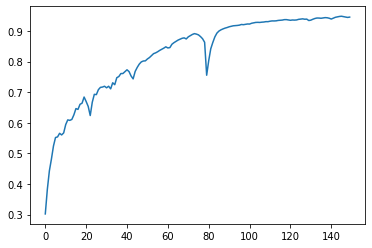

In [15]:
plt.plot(model_history.history["accuracy"])

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

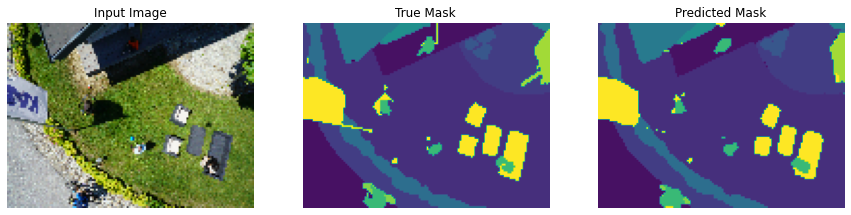

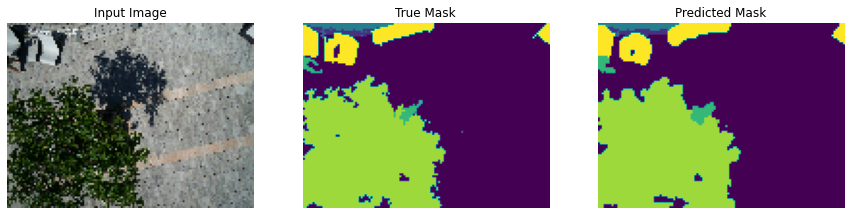

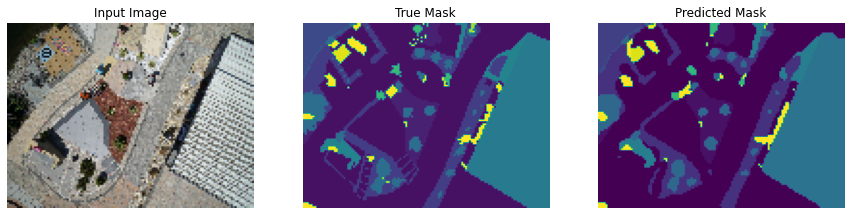

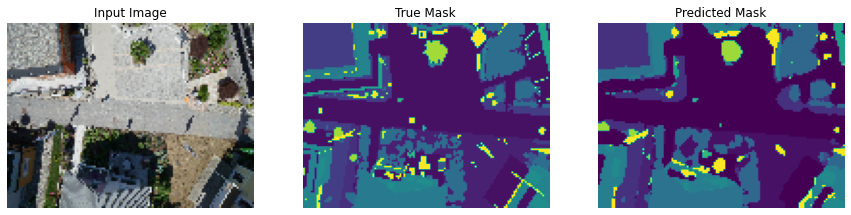

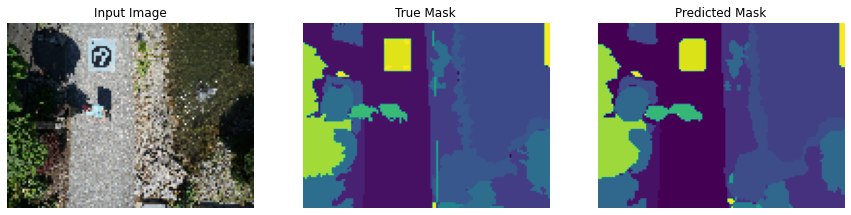

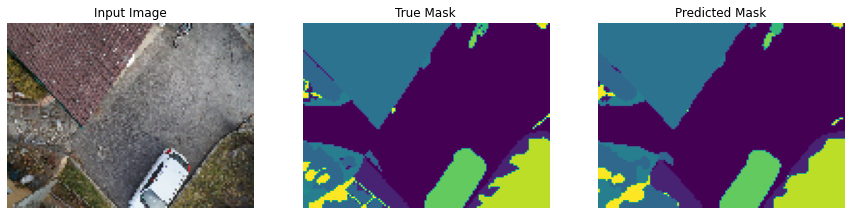

In [19]:
show_predictions(train_dataset, 6)